In [1]:
!pip install nltk
!pip install textblob
!pip install wordcloud

from warnings import filterwarnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("vader_lexicon")

filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 500)
pd.set_option("display.float_format", lambda x: '%.2f' % x)

  Using cached nltk-3.8.1-py3-none-any.whl.metadata (2.8 kB)
  Using cached regex-2023.12.25-cp311-cp311-win_amd64.whl.metadata (41 kB)
Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
Using cached regex-2023.12.25-cp311-cp311-win_amd64.whl (269 kB)


DEPRECATION: Loading egg at c:\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


   ---------------------------------------- 0.0/626.3 kB ? eta -:--:--
   - -------------------------------------- 30.7/626.3 kB ? eta -:--:--
   -- ------------------------------------ 41.0/626.3 kB 393.8 kB/s eta 0:00:02
   ---------------- ----------------------- 256.0/626.3 kB 2.0 MB/s eta 0:00:01
   ----------------------- ---------------- 368.6/626.3 kB 2.1 MB/s eta 0:00:01
   ---------------------------- ----------- 440.3/626.3 kB 2.1 MB/s eta 0:00:01
   ---------------------------------- ----- 532.5/626.3 kB 2.0 MB/s eta 0:00:01
   ---------------------------------------  624.6/626.3 kB 2.1 MB/s eta 0:00:01
   ---------------------------------------- 626.3/626.3 kB 2.0 MB/s eta 0:00:00


DEPRECATION: Loading egg at c:\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   ---------------- ----------------------- 122.9/300.2 kB 2.4 MB/s eta 0:00:01
   ----------------------- ---------------- 174.1/300.2 kB 3.5 MB/s eta 0:00:01
   ---------------------------------------  297.0/300.2 kB 2.6 MB/s eta 0:00:01
   ---------------------------------------- 300.2/300.2 kB 2.1 MB/s eta 0:00:00


DEPRECATION: Loading egg at c:\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...


In [2]:
df = pd.read_csv('../amazon_reviews.csv/amazon_reviews.csv',sep=",")
df.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4.00,No issues.,2014-07-23,138,0,0,0,0,0.00,0.00
1,1,0mie,5.00,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.00,0.00
2,2,1K3,4.00,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.00,0.00
3,3,1m2,5.00,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.00,0.00
4,4,2&amp;1/2Men,5.00,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.00,0.00


In [3]:
df
def text_preprocessing(dataframe, dependent_var):
  # Normalizing Case Folding - Uppercase to Lowercase
  dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x.lower() for x in str(x).split()))

  # Removing Punctuation
  dataframe[dependent_var] = dataframe[dependent_var].str.replace('[^\w\s]','')

  # Removing Numbers
  dataframe[dependent_var] = dataframe[dependent_var].str.replace('\d','')

  # StopWords
  sw = stopwords.words('english')
  dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

  # Remove Rare Words
  temp_df = pd.Series(' '.join(dataframe[dependent_var]).split()).value_counts()
  drops = temp_df[temp_df <= 1]
  dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x for x in str(x).split() if x not in drops))

  # Lemmatize
  dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

  return dataframe

In [4]:
df = text_preprocessing(df, "reviewText")

In [5]:
df["reviewText"].head()

0                                              issues.
1    purchased device, worked advertised. never muc...
2    work expected. higher capacity. think made bit...
3    think worked 64gb card went south 3 one held p...
4    bought retail packaging, arrived legit, versio...
Name: reviewText, dtype: object

In [6]:
def text_visulaization(dataframe, dependent_var, barplot=True, wordcloud=True):
  # Calculation of Term Frequencies
  tf = dataframe[dependent_var].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
  tf.columns = ["words", "tf"]

  if barplot:
    # Bar Plot
    tf[tf["tf"]>1000].plot.barh(x="words", y="tf")
    plt.title("Calculation of Term Frequencies : barplot")
    plt.show()

  if wordcloud:
    # WordCloud
    text = " ".join(i for i in dataframe[dependent_var])
    wordcloud = WordCloud(max_font_size=100, max_words=1000, background_color="white").generate(text)
    plt.figure(figsize=[10, 10])
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Calculation of Term Frequencies : wordcloud")
    plt.show()
    wordcloud.to_file("wordcloud.png")


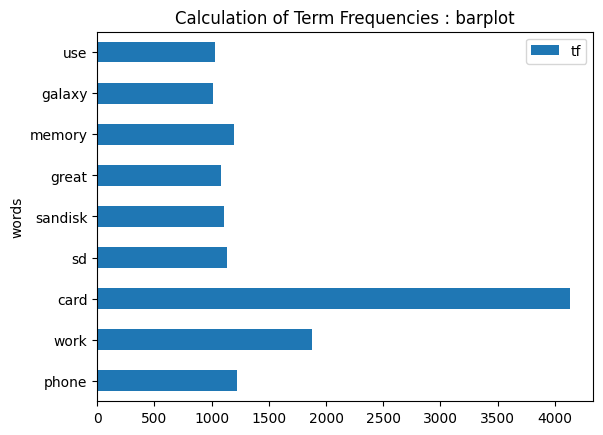

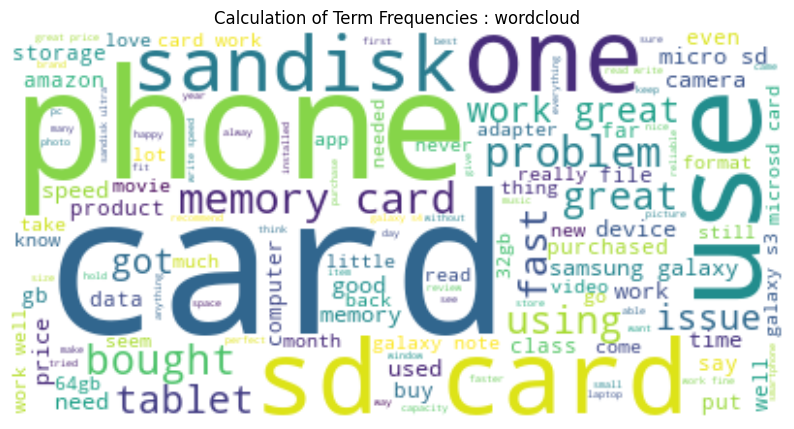

In [7]:
text_visulaization(df, "reviewText")

In [8]:
# Create Lables
def create_label(dataframe, dependent_var, independent_var):
  sia = SentimentIntensityAnalyzer()
  dataframe[independent_var] = dataframe[dependent_var].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")
  dataframe[independent_var] = LabelEncoder().fit_transform(dataframe[independent_var])

  X = dataframe[dependent_var]
  y = dataframe[independent_var]

  return X, y

In [9]:
X, y = create_label(df, "reviewText", "sentiment_label")

In [10]:
# Split Dataset
def split_dataset(dataframe, X, y):
  train_x, test_x, train_y, test_y = train_test_split(X, y, random_state=1)
  return train_x, test_x, train_y, test_y
train_x, test_x, train_y, test_y = split_dataset(df, X, y)

In [11]:
def create_features_count(train_x, test_x):
  # Count Vectors
  vectorizer = CountVectorizer()
  x_train_count_vectorizer = vectorizer.fit_transform(train_x)
  x_test_count_vectorizer = vectorizer.fit_transform(test_x)

  return x_train_count_vectorizer, x_test_count_vectorizer
x_train_count_vectorizer, x_test_count_vectorizer = create_features_count(train_x, test_x)

In [12]:
def create_features_TFIDF_word(train_x, test_x):
  # TF-IDF word
  tf_idf_word_vectorizer = TfidfVectorizer()
  x_train_tf_idf_word = tf_idf_word_vectorizer.fit_transform(train_x)
  x_test_tf_idf_word = tf_idf_word_vectorizer.fit_transform(test_x)

  return x_train_tf_idf_word, x_test_tf_idf_word
x_train_tf_idf_word, x_test_tf_idf_word = create_features_TFIDF_word(train_x, test_x)

In [13]:
def create_features_TFIDF_ngram(train_x, test_x):
  # TF-IDF ngram
  tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2,3))
  x_train_tf_idf_ngram = tf_idf_ngram_vectorizer.fit_transform(train_x)
  x_test_tf_idf_ngram = tf_idf_ngram_vectorizer.fit_transform(test_x)

  return x_train_tf_idf_ngram, x_test_tf_idf_ngram
x_train_tf_idf_ngram, x_test_tf_idf_ngram = create_features_TFIDF_ngram(train_x, test_x)

In [14]:
def create_features_TFIDF_chars(train_x, test_x):
  # TF-IDF Characters
  tf_idf_chars_vectorizer = TfidfVectorizer(analyzer="char", ngram_range=(2,3))
  x_train_tf_idf_chars = tf_idf_chars_vectorizer.fit_transform(train_x)
  x_test_tf_idf_chars = tf_idf_chars_vectorizer.fit_transform(test_x)

  return x_train_tf_idf_chars, x_test_tf_idf_chars
x_train_tf_idf_chars, x_test_tf_idf_chars = create_features_TFIDF_chars(train_x, test_x)

In [15]:
# Logistic Regression
def crate_model_logistic(train_x, test_x):
  # Count
  x_train_count_vectorizer, x_test_count_vectorizer = create_features_count(train_x, test_x)
  loj_count = LogisticRegression(solver='lbfgs', max_iter=1000)
  loj_model_count = loj_count.fit(x_train_count_vectorizer, train_y)
  accuracy_count = cross_val_score(loj_model_count, x_test_count_vectorizer, test_y, cv=10).mean()
  print("Accuracy - Count Vectors: %.3f" % accuracy_count)

  # TF-IDF Word
  x_train_tf_idf_word, x_test_tf_idf_word = create_features_TFIDF_word(train_x, test_x)
  loj_word = LogisticRegression(solver='lbfgs', max_iter=1000)
  loj_model_word = loj_word.fit(x_train_tf_idf_word, train_y)
  accuracy_word = cross_val_score(loj_model_word, x_test_tf_idf_word, test_y, cv=10).mean()
  print("Accuracy - TF-IDF Word: %.3f" % accuracy_word)

  # TF-IDF ngram
  x_train_tf_idf_ngram, x_test_tf_idf_ngram = create_features_TFIDF_ngram(train_x, test_x)
  loj_ngram = LogisticRegression(solver='lbfgs', max_iter=1000)
  loj_model_ngram = loj_ngram.fit(x_train_tf_idf_ngram, train_y)
  accuracy_ngram = cross_val_score(loj_model_ngram, x_test_tf_idf_ngram, test_y, cv=10).mean()
  print("Accuracy TF-IDF ngram: %.3f" % accuracy_ngram)

  # TF-IDF chars

  loj_chars = LogisticRegression(solver='lbfgs', max_iter=1000)
  loj_model_chars = loj_chars.fit(x_train_tf_idf_chars, train_y)
  accuracy_chars = cross_val_score(loj_model_chars, x_test_tf_idf_chars, test_y, cv=10).mean()
  print("Accuracy TF-IDF Characters: %.3f" % accuracy_chars)

  return loj_model_count, loj_model_word, loj_model_ngram, loj_model_chars
loj_model_count, loj_model_word, loj_model_ngram, loj_model_chars = crate_model_logistic(train_x, test_x)

Accuracy - Count Vectors: 0.832
Accuracy - TF-IDF Word: 0.806
Accuracy TF-IDF ngram: 0.807
Accuracy TF-IDF Characters: 0.807


In [16]:
# Random Forest
def crate_model_randomforest(train_x, test_x):
  # Count
  x_train_count_vectorizer, x_test_count_vectorizer = create_features_count(train_x, test_x)
  rf_count = RandomForestClassifier()
  rf_model_count = rf_count.fit(x_train_count_vectorizer, train_y)
  accuracy_count = cross_val_score(rf_model_count, x_test_count_vectorizer, test_y, cv=10).mean()
  print("Accuracy - Count Vectors: %.3f" % accuracy_count)

  # TF-IDF Word
  x_train_tf_idf_word, x_test_tf_idf_word = create_features_TFIDF_word(train_x, test_x)
  rf_word = RandomForestClassifier()
  rf_model_word = rf_word.fit(x_train_tf_idf_word, train_y)
  accuracy_word = cross_val_score(rf_model_word, x_test_tf_idf_word, test_y, cv=10).mean()
  print("Accuracy - TF-IDF Word: %.3f" % accuracy_word)

  # TF-IDF ngram
  x_train_tf_idf_ngram, x_test_tf_idf_ngram = create_features_TFIDF_ngram(train_x, test_x)
  rf_ngram = RandomForestClassifier()
  rf_model_ngram = rf_ngram.fit(x_train_tf_idf_ngram, train_y)
  accuracy_ngram = cross_val_score(rf_model_ngram, x_test_tf_idf_ngram, test_y, cv=10).mean()
  print("Accuracy TF-IDF ngram: %.3f" % accuracy_ngram)

  # TF-IDF chars

  rf_chars = RandomForestClassifier()
  rf_model_chars = rf_chars.fit(x_train_tf_idf_chars, train_y)
  accuracy_chars = cross_val_score(rf_model_chars, x_test_tf_idf_chars, test_y, cv=10).mean()
  print("Accuracy TF-IDF Characters: %.3f" % accuracy_chars)

  return rf_model_count, rf_model_word, rf_model_ngram, rf_model_chars
rf_model_count, rf_model_word, rf_model_ngram, rf_model_chars = crate_model_randomforest(train_x, test_x)

Accuracy - Count Vectors: 0.810
Accuracy - TF-IDF Word: 0.806
Accuracy TF-IDF ngram: 0.721
Accuracy TF-IDF Characters: 0.807


In [17]:
def model_tuning_randomforest(train_x, test_x):
  # Count
  x_train_count_vectorizer, x_test_count_vectorizer = create_features_count(train_x, test_x)
  rf_model_count = RandomForestClassifier(random_state=1)
  rf_params = {"max_depth": [2,5,8, None],
               "max_features": [2,5,8, "auto"],
               "n_estimators": [100,500,1000],
               "min_samples_split": [2,5,10]}
  rf_best_grid = GridSearchCV(rf_model_count, rf_params, cv=10, n_jobs=-1, verbose=False).fit(x_train_count_vectorizer, train_y)
  rf_model_count_final = rf_model_count.set_params(**rf_best_grid.best_params_, random_state=1).fit(x_train_count_vectorizer, train_y)
  accuracy_count = cross_val_score(rf_model_count_final, x_test_count_vectorizer, test_y, cv=10).mean()
  print("Accuracy - Count Vectors: %.3f" % accuracy_count)

  return rf_model_count_final
rf_model_count_final = model_tuning_randomforest(train_x, test_x)

Accuracy - Count Vectors: 0.808


In [23]:

def predict_count(train_x, model, new_comment):
  new_comment= pd.Series(new_comment)
  new_comment = CountVectorizer().fit(train_x).transform(new_comment)
  result = model.predict(new_comment)
  if result==1:
    print("Comment is Pozitive")
  else:
    print("Comment is Negative")
    # Logistic Regression

com = input("Please enter a comment: ")
predict_count(train_x, model=loj_model_count, new_comment = com)

Comment is Pozitive


In [19]:
# Function to save comments and predictions to a CSV file
def save_comments_to_csv(comments, model, vectorizer, file_name):
    # Predict sentiment for each comment
    predictions = [predict_sentiment(comment, model, vectorizer) for comment in comments]

    # Create a DataFrame to store comments and predictions
    df = pd.DataFrame({"Comment": comments, "Sentiment": predictions})

    # Save DataFrame to CSV file
    df.to_csv(file_name, index=False)

# Define a list of comments
comments = [
    "I loved this product! It exceeded my expectations.",
    "Terrible product, I would not recommend it to anyone.",
    "Average performance, nothing exceptional.",
    "Absolutely amazing, worth every penny!"
]

# Define the file name for the CSV file
file_name = "comments_with_predictions.csv"

# Save comments and predictions to CSV file
save_comments_to_csv(comments, loj_model_count, CountVectorizer().fit(train_x), file_name)

print(f"Comments and predictions saved to '{file_name}' successfully.")


NameError: name 'predict_sentiment' is not defined

Sentimental Analysis(with csv)

In [ ]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

# Function for text preprocessing
def text_preprocessing(dataframe, dependent_var):
    # Normalizing Case Folding - Uppercase to Lowercase
    dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x.lower() for x in str(x).split()))

    # Removing Punctuation
    dataframe[dependent_var] = dataframe[dependent_var].str.replace('[^\w\s]', '')

    # Removing Numbers
    dataframe[dependent_var] = dataframe[dependent_var].str.replace('\d', '')

    # StopWords
    sw = stopwords.words('english')
    dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

    # Remove Rare Words
    temp_df = pd.Series(' '.join(dataframe[dependent_var]).split()).value_counts()
    drops = temp_df[temp_df <= 1]
    dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x for x in str(x).split() if x not in drops))

    # Lemmatize
    dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

    return dataframe

# Function for performing sentiment analysis
def perform_sentiment_analysis(dataframe, dependent_var):
    sia = SentimentIntensityAnalyzer()
    dataframe['sentiment_score'] = dataframe[dependent_var].apply(lambda x: sia.polarity_scores(x)["compound"])
    dataframe['sentiment_label'] = dataframe['sentiment_score'].apply(lambda score: "pos" if score > 0 else "neg")
    return dataframe

# Load the data
df = pd.read_csv('../amazon_reviews.csv/amazon_reviews.csv', sep=",")

# Preprocess the text data
df = text_preprocessing(df, "reviewText")

# Perform sentiment analysis
df = perform_sentiment_analysis(df, "reviewText")

# Save sentiment analysis results to CSV
df.to_csv("sentiment_analysis_results.csv", index=False)